In [4]:
# make sure to install anndata, scanpy, numpy, pandas, matplotlib before running this script

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'file.h5ad' with your file path
adata = anndata.read_h5ad('adata_head_S_v1.0.h5ad')
#adata = anndata.read_h5ad('adata_body_S_v1.0.h5ad')

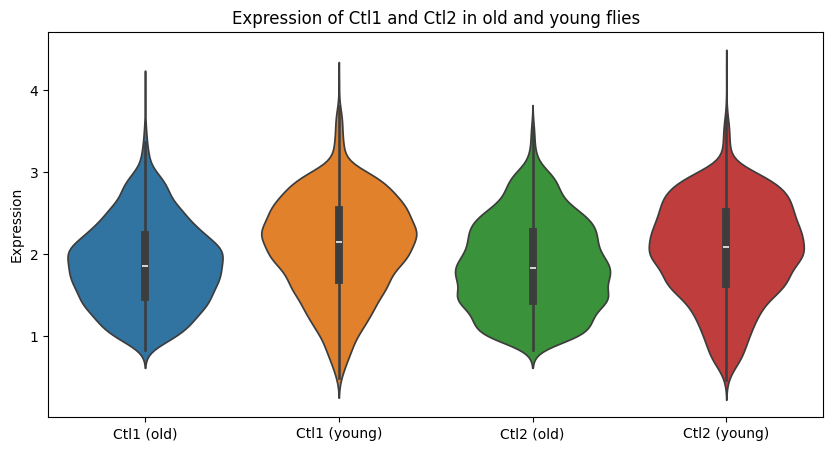

Mean expression of Ctl1 in old flies: 1.8757789
Mean expression of Ctl2 in old flies: 1.8626643
Mean expression of Ctl1 in young flies: 2.0980144
Mean expression of Ctl2 in young flies: 2.0502243
T-test for Ctl1 between old and young:
T-statistic: -15.231133503265255
p-value: 2.1434457278911438e-51

T-test for Ctl2 between old and young:
T-statistic: -12.683923283302718
p-value: 2.0980313324617715e-36


In [143]:
# Exploratory data analysis (very crude) looking at differential expression of CTL1 and CTL2 in old and young flies 
gene_names = adata.var_names
cell_gene_matrix = adata.X.toarray()

# index of "Ctl1" and "Ctl2" in the gene_names
ctl1_idx = np.where(gene_names == "Ctl1")[0][0]
ctl2_idx = np.where(gene_names == "Ctl2")[0][0]

# Get the expression of "Ctl1" and "Ctl2" in all cells
ctl1_expression = cell_gene_matrix[:, ctl1_idx]
ctl2_expression = cell_gene_matrix[:, ctl2_idx]

# remove outliers and also remove cells with 0 expression
ctl1_filter = (ctl1_expression > 0) & (ctl1_expression < 100)
ctl2_filter = (ctl2_expression > 0) & (ctl2_expression < 100)

# compare ctl1 and ctl2 expression between old (age = 70) and young (age = 5) flies 
ages = adata.obs["age"].to_numpy(dtype = int)
ctl1_old = ctl1_filter & (ages == 70)
ctl2_old = ctl2_filter & (ages == 70)
ctl1_young = ctl1_filter & (ages == 5)
ctl2_young = ctl2_filter & (ages == 5)

ctl1_expression_old = ctl1_expression[ctl1_old]
ctl2_expression_old = ctl2_expression[ctl2_old]
ctl1_expression_young = ctl1_expression[ctl1_young]
ctl2_expression_young = ctl2_expression[ctl2_young]

# create violin plot for "Ctl1" and "Ctl2" in old and young flies
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.violinplot(data=[ctl1_expression_old, ctl1_expression_young, ctl2_expression_old, ctl2_expression_young])
plt.xticks([0, 1, 2, 3], ["Ctl1 (old)", "Ctl1 (young)", "Ctl2 (old)", "Ctl2 (young)"])
plt.ylabel("Expression")
plt.title("Expression of Ctl1 and Ctl2 in old and young flies")
plt.show()

# calculate the mean expression of "Ctl1" and "Ctl2" in old and young flies
ctl1_mean_old = np.mean(ctl1_expression_old)
ctl2_mean_old = np.mean(ctl2_expression_old)
ctl1_mean_young = np.mean(ctl1_expression_young)
ctl2_mean_young = np.mean(ctl2_expression_young)

print("Mean expression of Ctl1 in old flies:", ctl1_mean_old)
print("Mean expression of Ctl2 in old flies:", ctl2_mean_old)
print("Mean expression of Ctl1 in young flies:", ctl1_mean_young)
print("Mean expression of Ctl2 in young flies:", ctl2_mean_young)

from scipy import stats

# Perform t-test for "Ctl1"
t_statistic, p_value = stats.ttest_ind(ctl1_expression_old, ctl1_expression_young, equal_var=False)
print("T-test for Ctl1 between old and young:")
print("T-statistic:", t_statistic)
print("p-value:", p_value)

# Perform t-test for "Ctl2"
t_statistic, p_value = stats.ttest_ind(ctl2_expression_old, ctl2_expression_young, equal_var=False)
print("\nT-test for Ctl2 between old and young:")
print("T-statistic:", t_statistic)
print("p-value:", p_value)

In [145]:
# Assuming data is already loaded in an AnnData object (adata)
adata = anndata.read_h5ad('adata_head_S_v1.0.h5ad')

# Subset data for genes of interest
genes_of_interest = ["Ctl1", "Ctl2"]
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]
adata_subset

View of AnnData object with n_obs × n_vars = 289981 × 2
    obs: 'tissue', 'sex', 'age', 'sex_age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'dataset', 'fca_annotation', 'afca_annotation', 'afca_annotation_broad'
    uns: 'afca_annotation_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

Ctl1: p-val = 1.7074120935857826e-49, corrected p-val = 3.4148241871715653e-49, t-stat = -14.926879489862825
Ctl2: p-val = 1.5930220812728502e-36, corrected p-val = 1.5930220812728502e-36, t-stat = -12.704779369580182


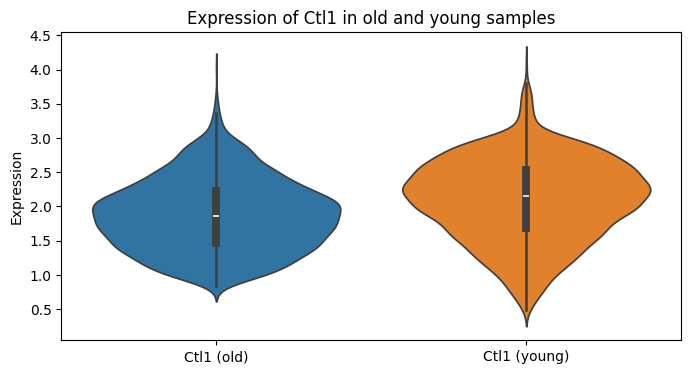

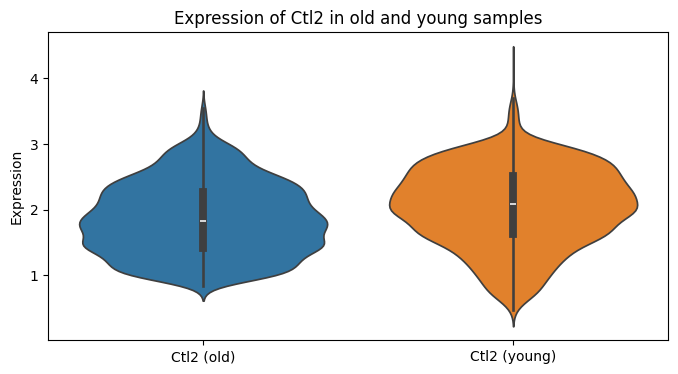

In [4]:
# Differential gene expression across all cells between old and young flies 

import scanpy as sc
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Load the AnnData object
adata = sc.read_h5ad('adata_head_S_v1.0.h5ad')

# Define genes of interest
genes_of_interest = ["Ctl1", "Ctl2"]

# Subset the data to include only genes of interest
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]

# Initialize lists to store p-values and results for plotting
p_vals = []
t_vals = []
violin_data = []

for gene in genes_of_interest:
    # Find the index of the current gene
    gene_idx = np.where(adata.var_names.to_numpy() == gene)[0][0]
    
    # Extract the expression data for the current gene
    gene_expression = adata[:, gene_idx].X.A.flatten()
    
    # Filter cells based on positive expression of the current gene
    gene_filter = gene_expression > 0
    
    # Apply the filter
    valid_cells = gene_filter
    adata_gene = adata[valid_cells, :]
    gene_expression = gene_expression[valid_cells]
    
    # Separate old and young samples
    old_samples = adata_gene.obs['age'].to_numpy(dtype=int) == 70
    young_samples = adata_gene.obs['age'].to_numpy(dtype=int) == 5
    
    # Extract gene expression data for old and young samples
    gene_expression_old = gene_expression[old_samples]
    gene_expression_young = gene_expression[young_samples]
    
    # Perform t-test
    t_stat, p_val = ttest_ind(gene_expression_old, gene_expression_young)
    p_vals.append(p_val)
    t_vals.append(t_stat)
    
    # Store data for violin plot
    violin_data.append((gene, gene_expression_old, gene_expression_young))

# Correct for multiple testing
corrected_p_vals = multipletests(p_vals, method='fdr_bh')[1]

# Print results
for i, gene in enumerate(genes_of_interest):
    print(f"{gene}: p-val = {p_vals[i]}, corrected p-val = {corrected_p_vals[i]}, t-stat = {t_vals[i]}")

# Plot violin plots
for gene, gene_expression_old, gene_expression_young in violin_data:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=[gene_expression_old, gene_expression_young])
    plt.xticks([0, 1], [f"{gene} (old)", f"{gene} (young)"])
    plt.ylabel("Expression")
    plt.title(f"Expression of {gene} in old and young samples")
    plt.show()

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Load the AnnData object
adata = sc.read_h5ad('adata_head_S_v1.0.h5ad')

# Define genes of interest
genes_of_interest = ["Ctl1", "Ctl2", "Pld", "Gr47a", "slif", "upd1", "FMRFa", "FMRFaR", "Ms", "MsR2"]

# Subset the data to include only genes of interest
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]

# Initialize lists to store p-values and results for plotting
p_vals = []
regression_results = []

# Define colors for age groups
age_colors = {'5': 'blue', '30': 'green', '50': 'orange', '70': 'red'}

# Loop through each gene of interest
for gene in genes_of_interest:
    # Find the index of the current gene
    gene_idx = np.where(adata.var_names.to_numpy() == gene)[0][0]
    
    # Extract the expression data for the current gene
    gene_expression = adata[:, gene_idx].X.A.flatten()
    
    # Filter cells based on positive expression of the current gene
    gene_filter = gene_expression > 0

    # Filter only the dopaminergic PAM neurons
    cell_filter = adata.obs['afca_annotation'] == 'distal medullary amacrine neuron Dm3'
    
    # Apply the filter
    valid_cells = gene_filter
    adata_gene = adata[valid_cells, :]
    gene_expression = gene_expression[valid_cells]
    
    # Extract age data
    ages = adata_gene.obs['age'].to_numpy(dtype=int)
    
    # Perform linear regression
    X = sm.add_constant(ages)  # Add an intercept to the model
    model = sm.OLS(gene_expression, X).fit()
    
    # Get the p-value for the age coefficient
    p_val = model.pvalues[1]
    p_vals.append(p_val)
    regression_results.append((gene, model))
    
    # Store data for violin plot
    adata_gene.obs['gene_expression'] = gene_expression
    violin_data = adata_gene.obs[['age', 'gene_expression']]

    # Plot violin plot
    plt.figure(figsize=(8, 4))
    sns.violinplot(x='age', y='gene_expression', data=violin_data, palette=age_colors)
    plt.ylabel("Expression")
    plt.title(f"Expression of {gene} across age groups")
    plt.show()
    
    # Plot scatter plot with regression line
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=ages, y=gene_expression, hue=ages)
    plt.plot(ages, model.predict(X), color='black', linestyle='--')
    plt.xlabel("Age")
    plt.ylabel("Expression")
    plt.title(f"Scatter plot of {gene} expression vs. age with regression line")
    plt.legend(title='Age')
    plt.show()

# Correct for multiple testing
corrected_p_vals = multipletests(p_vals, method='fdr_bh')[1]

# Print results
for i, (gene, model) in enumerate(regression_results):
    print(f"{gene}: p-val = {p_vals[i]}, corrected p-val = {corrected_p_vals[i]}")
    print(model.summary())

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the AnnData object
adata = sc.read_h5ad('adata_head_S_v1.0.h5ad')

# Define genes of interest
genes_of_interest = ["Ctl1", "Ctl2", "Pld", "Gr47a", "slif", "upd1", "FMRFa", "FMRFaR", "Ms", "MsR2"]

# Subset the data to include only genes of interest
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]

# Initialize a dictionary to store average expressions
average_expressions = {gene: {} for gene in genes_of_interest}

# Loop through each gene of interest
for gene in genes_of_interest:
    # Find the index of the current gene
    gene_idx = np.where(adata.var_names.to_numpy() == gene)[0][0]
    
    # Extract the expression data for the current gene
    gene_expression = adata[:, gene_idx].X.A.flatten()
    
    # Filter out cells with 0 expression
    gene_filter = gene_expression > 0
    filtered_adata = adata[gene_filter, :]
    gene_expression = gene_expression[gene_filter]
    
    # Add gene expression to the filtered AnnData object
    filtered_adata.obs[gene] = gene_expression
    
    # Calculate average expression per cell type
    avg_expression = filtered_adata.obs.groupby('afca_annotation')[gene].mean()
    
    # Store the average expressions
    average_expressions[gene] = avg_expression

# Convert the dictionary to a DataFrame for easy ranking and plotting
avg_expr_df = pd.DataFrame(average_expressions)

# Loop through each gene of interest and print the top 10 cell types with the highest average expression
for gene in genes_of_interest:
    # Sort the cell types by average expression in descending order
    sorted_avg_expr = avg_expr_df[gene].sort_values(ascending=False)
    
    # Get the top 10 cell types
    top_10_cell_types = sorted_avg_expr.head(10)
    
    # Print the results
    print(f"Top 10 cell types with the highest average expression for {gene}:")
    print(top_10_cell_types)
    print("\n")

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the AnnData object
adata = sc.read_h5ad('adata_head_S_v1.0.h5ad')

# Define genes of interest
genes_of_interest = ["Ctl1", "Ctl2", "Pld", "Gr47a", "slif", "upd1", "FMRFa", "FMRFaR", "Ms", "MsR2"]

# Subset the data to include only genes of interest
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]

# Initialize a list to store the results
results = []

# Loop through each gene of interest
for gene in genes_of_interest:
    # Find the index of the current gene
    gene_idx = np.where(adata.var_names.to_numpy() == gene)[0][0]
    
    # Extract the expression data for the current gene
    gene_expression = adata[:, gene_idx].X.A.flatten()
    
    # Filter out cells with 0 expression
    gene_filter = gene_expression > 0
    filtered_adata = adata[gene_filter, :]
    gene_expression = gene_expression[gene_filter]
    
    # Add gene expression to the filtered AnnData object
    filtered_adata.obs[gene] = gene_expression
    
    # Calculate average expression per cell type per age
    avg_expression = filtered_adata.obs.groupby(['age', 'afca_annotation'])[gene].mean().reset_index()
    
    # Sort and select top 10 cell types per age group
    for age in avg_expression['age'].unique():
        age_group_df = avg_expression[avg_expression['age'] == age]
        sorted_avg_expr = age_group_df.sort_values(by=gene, ascending=False).head(10)
        
        for _, row in sorted_avg_expr.iterrows():
            results.append({
                'Gene': gene,
                'Age': age,
                'Cell Type': row['afca_annotation'],
                'Average Expression': row[gene]
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset the data to include only genes of interest
adata_subset = adata[:, np.isin(adata.var_names.to_numpy(), genes_of_interest)]

# Create a dataframe for correlation heatmap
heatmap_data = adata_subset.to_df()

# Remove samples with no expression in any of the genes of interest
heatmap_data = heatmap_data[(heatmap_data > 0).any(axis=1)]

# Calculate the correlation matrix
correlation_matrix = heatmap_data[genes_of_interest].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Gene Expression Levels')
plt.xlabel('Genes')
plt.ylabel('Genes')
plt.show()

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt 
X = adata.obsm["X_umap"]

age = np.array(adata.obs['age'], dtype = np.int32)
five = np.isin(age, 5)
seventy = np.isin(age, 70)

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].scatter(x = X[seventy, 0], y = X[seventy, 1], s = 0.05, c = color_map[seventy])
axes[0].set_title('Age 70')
axes[1].scatter(x = X[five, 0], y = X[five, 1], s = 0.05, c = color_map[five])
axes[1].set_title('Age 5')
plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('GrayRed', ['gray', 'yellow', 'orange', 'red'])

# Extract the t-SNE embedding
X_tsne = adata.obsm['X_tsne']
ages = adata.obs['age'].to_numpy(dtype=int)

genes_of_interest = ["Ctl1", "Ctl2", "Pld", "Gr47a", "slif", "upd1", "FMRFa", "FMRFaR", "Ms", "MsR2"]
ctl1_expression = adata.X[:, np.where(adata.var_names == 'Pld')[0][0]].toarray().flatten()

tsne_5 = X_tsne[ages == 5]
tsne_30 = X_tsne[ages == 30]
tsne_50 = X_tsne[ages == 50]
tsne_70 = X_tsne[ages == 70]

# Determine the range of the expression values
vmin = ctl1_expression.min()
vmax = ctl1_expression.max()

# Plot the t-SNE visualization by age group. create 2 x 2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot age 5
sc = axes[0, 0].scatter(tsne_5[:, 0], tsne_5[:, 1], c=ctl1_expression[ages == 5], cmap=cmap, s=5, vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Age 5')

# Plot age 30
sc = axes[0, 1].scatter(tsne_30[:, 0], tsne_30[:, 1], c=ctl1_expression[ages == 30], cmap=cmap, s=5, vmin=vmin, vmax=vmax)
axes[0, 1].set_title('Age 30')

# Plot age 50
sc = axes[1, 0].scatter(tsne_50[:, 0], tsne_50[:, 1], c=ctl1_expression[ages == 50], cmap=cmap, s=5, vmin=vmin, vmax=vmax)
axes[1, 0].set_title('Age 50')

# Plot age 70
sc = axes[1, 1].scatter(tsne_70[:, 0], tsne_70[:, 1], c=ctl1_expression[ages == 70], cmap=cmap, s=5, vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Age 70')

# Add colorbar
fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', label='Ctl1 expression')

plt.show()


In [95]:
# Tool for visualizing t-SNE embeddings colored by gene expression and grouped by age

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import plotly.io as pio
import webbrowser

degs_glia = ['CG9360', 'Cyp28a5', 'GstE12', 'GstE1', 'mdh1', 'Ssadh', 'Ugt86Dd', 
             'Rpl41', 'Cct2', 'CG34362', 'CG6770', 'sm', 'CG31324', 'vri']

gene = 'Pld'
# Extract the t-SNE embedding
X_tsne = adata.obsm['X_tsne']
ages = adata.obs['age'].to_numpy(dtype=int)
gene_expression = adata.X[:, np.where(adata.var_names == gene)[0][0]].toarray().flatten()
cell_types = adata.obs['afca_annotation'].to_numpy()  # Extract cell types

# Create a DataFrame for easy plotting
df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df['Age'] = ages
df['Gene Expression'] = gene_expression
df['Cell Type'] = cell_types

df = df.sort_values(by='Gene Expression')

# Define age groups
age_groups = [5, 30, 50, 70]

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Age {age}' for age in age_groups])

for i, age in enumerate(age_groups):
    row = i // 2 + 1
    col = i % 2 + 1
    age_df = df[df['Age'] == age]
    scatter = go.Scatter(
        x=age_df['TSNE1'], y=age_df['TSNE2'], mode='markers',
        marker=dict(
            size=3,  # Smaller marker size
            color=age_df['Gene Expression'],
            colorscale='YlOrRd',
            showscale=(row == 1 and col == 2),  # Only show colorbar for one subplot
            colorbar=dict(title=f'{gene} Expression', x=1.1, y=0.5, len = 0.5)  # Move colorbar out of the way
        ),
        text=age_df['Cell Type'],  # Hover text
        hoverinfo='text', 
        showlegend=False
    )
    fig.add_trace(scatter, row=row, col=col)

fig.update_layout(
    height=700,  # Larger overall plot height
    width=700,  # Larger overall plot width
    title_text=f"t-SNE visualization by age group for {gene}"
)

# Save the plot as an HTML file
html_file = f"tsne_visualization_{gene}_body.html"
pio.write_html(fig, file=html_file, auto_open=True)

# Open the plot in the default web browser
webbrowser.open(html_file)


True

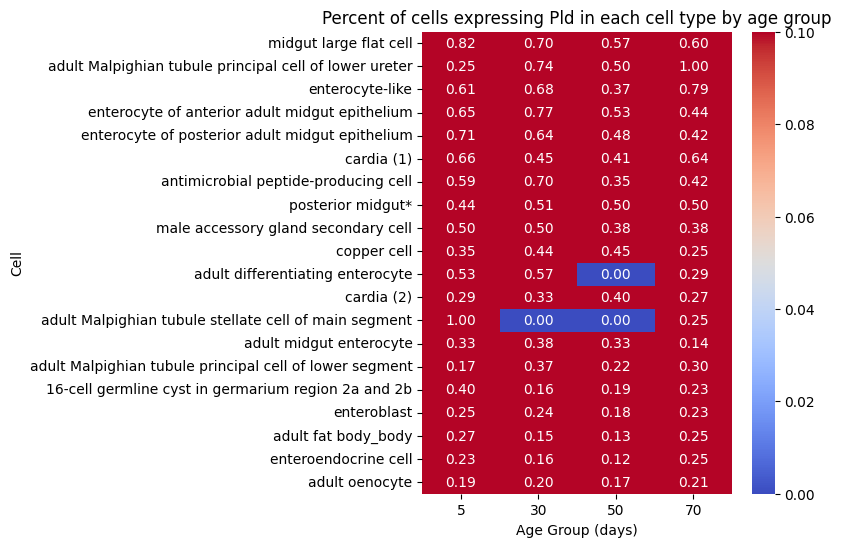

In [134]:
# heat map showing the percent of cells in each cell type expressing gene of interest (e.g. Ctl1) for each age group

import seaborn as sns
import matplotlib.pyplot as plt
import numpy

gene = 'Pld'
all_cells = adata.obs['afca_annotation'].unique()

df = pd.DataFrame(columns=['Cell', '5', '30', '50', '70'])
df['Cell'] = all_cells
for age in [5, 30, 50, 70]:
    cell_data = []
    for cell in all_cells:
        age_data = adata[(adata.obs['afca_annotation'] == cell) & (np.array(adata.obs['age'], dtype=int) == age)]
        temp = age_data.X[:, np.where(adata.var_names == gene)[0][0]].toarray().flatten()
        cell_data.append(len(temp[temp > 0])/len(temp)) if len(temp) > 0 else cell_data.append(0)
        #cell_data.append(np.mean(temp))
    df[str(age)] = cell_data

# sort the rows of the df by the average of each row
df['mean'] = df[['5', '30', '50', '70']].mean(axis=1)
df.sort_values(by='mean', ascending=False, inplace=True)
df.drop(columns='mean', inplace=True)

# get the first 20 rows
df = df.head(20)

# Create a heatmap
plt.figure(figsize=(5, 6))
sns.heatmap(df.set_index('Cell'), cmap='coolwarm', annot=True, fmt=".2f", vmin = 0, vmax=0.1)
plt.title(f'Percent of cells expressing {gene} in each cell type by age group')
plt.xlabel('Age Group (days)')
plt.show()

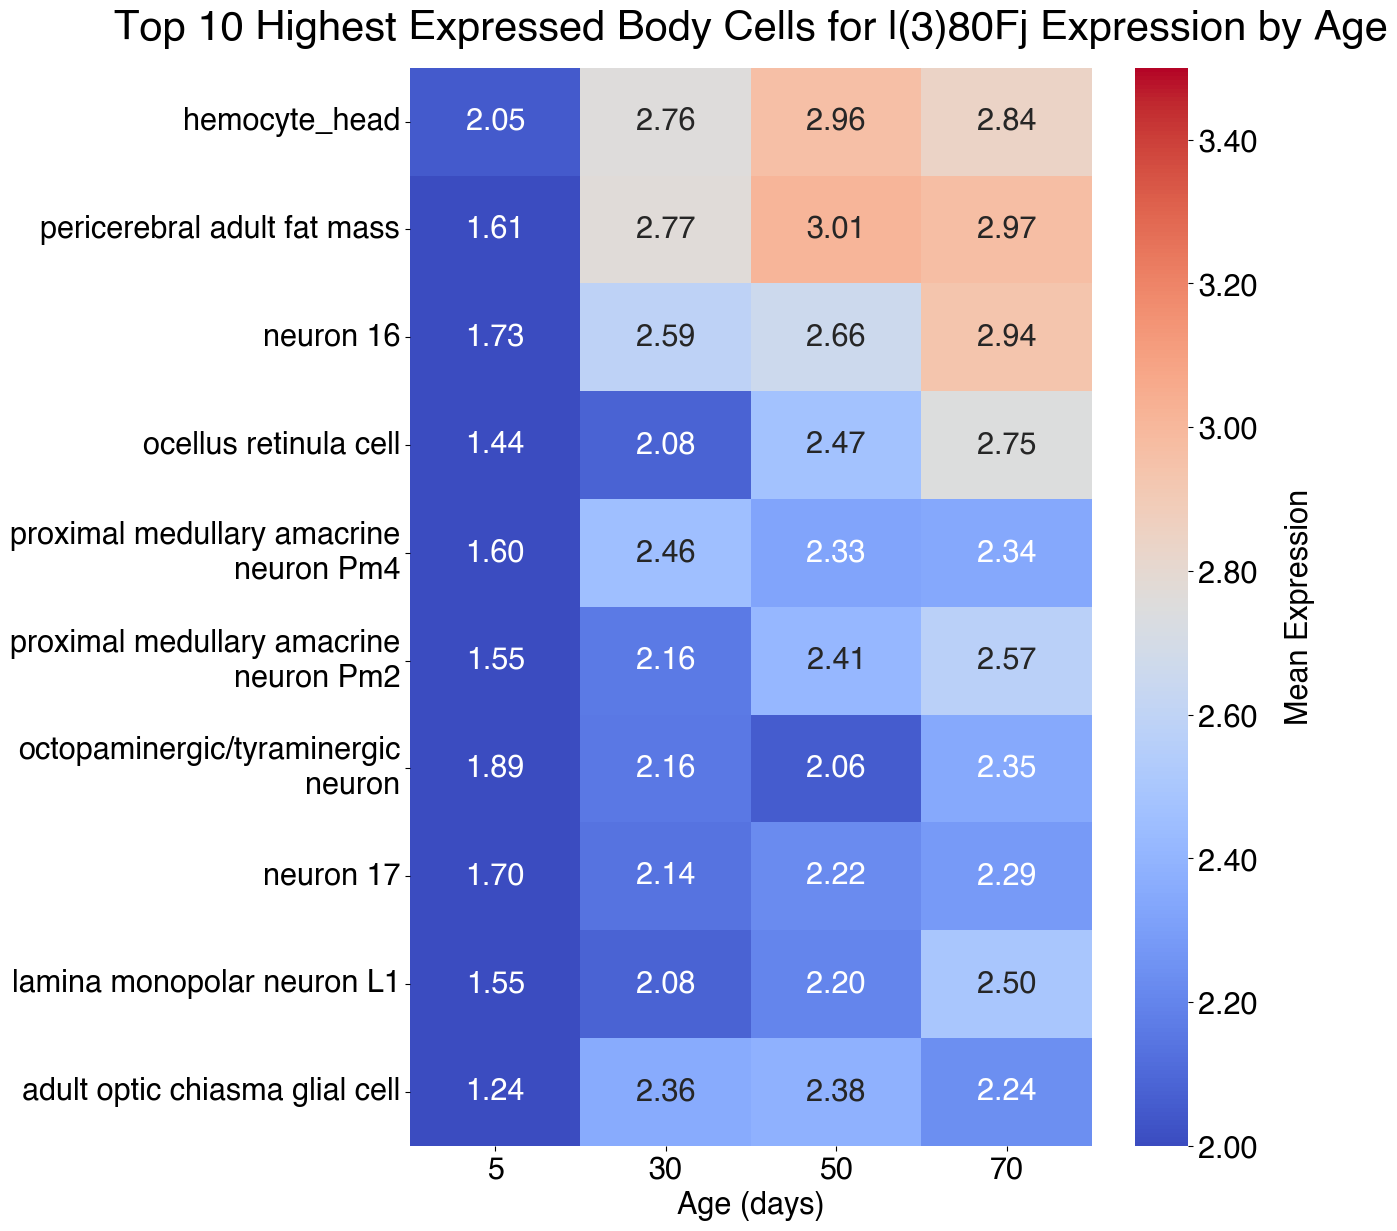

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textwrap

gene = 'l(3)80Fj'
all_cells = adata.obs['afca_annotation'].unique()
# all_cells = ["midgut large flat cell", "enterocyte of anterior adult midgut epithelium", "posterior midgut*", "enterocyte of posterior adult midgut epithelium"]

df = pd.DataFrame(columns=['Cell', '5', '30', '50', '70'])
df['Cell'] = all_cells

freq_df = pd.DataFrame(columns=['Cell', '5', '30', '50', '70'])
freq_df['Cell'] = all_cells

for age in [5, 30, 50, 70]:
    cell_data = []
    freq_data = []
    for cell in all_cells:
        age_data = adata[(adata.obs['afca_annotation'] == cell) & (np.array(adata.obs['age'], dtype=int) == age)]
        temp = age_data.X[:, np.where(adata.var_names == gene)[0][0]].toarray().flatten()
        freq_data.append(len(temp[temp > 0])/len(temp)) if len(temp) > 0 else freq_data.append(0)

        # total expression
        val = np.mean(temp[temp >= 0]) if len(temp[temp >= 0]) > 0 else 0

        # active expression
        # val = np.mean(temp[temp > 0]) if len(temp[temp > 0]) > 0 else 0

        cell_data.append(val)
    df[str(age)] = cell_data
    freq_df[str(age)] = freq_data

# sort the rows of the df by the average of each row
freq_df['mean'] = freq_df[['5', '30', '50', '70']].mean(axis=1)
freq_df.sort_values(by='mean', ascending=False, inplace=True)
freq_df.drop(columns='mean', inplace=True)

# use the same order as the freq_df
df['mean'] = df[['5', '30', '50', '70']].mean(axis=1)
df.sort_values(by='mean', ascending=False, inplace=True)
df.drop(columns='mean', inplace=True)

# get the first 10 rows
df = df.head(10)

# Create a heatmap
plt.figure(figsize=(11, 14))
sns.heatmap(df.set_index('Cell'), cmap='coolwarm', annot=True, fmt=".2f", vmin=2, vmax=3.5,
            annot_kws={"size": 22}, cbar_kws={'label': 'Expression Level', 'format': '%.2f'})
plt.title(f'Top 10 Highest Expressed Body Cells for {gene} Expression by Age', fontsize=30, fontweight='bold', pad = 20)
plt.xlabel('Age (days)', fontsize=22, fontweight='bold')
plt.xticks(fontsize=22, fontweight='bold')

# Adjust the labels to be less crowded and highlight specific labels
yticklabels = plt.gca().get_yticklabels()
labels = [textwrap.fill(label.get_text(), 30) for label in yticklabels]
plt.yticks(plt.yticks()[0], labels, fontsize=22, fontweight='bold')

# Highlight "glial cell" labels in red
for label in yticklabels:
    if "enterocyte" in label.get_text() or "gut" in label.get_text():
        label.set_color("blue")

plt.ylabel('')

# Make the numbers on the legend bigger
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Mean Expression', size=22, weight='bold', labelpad=20)

# Helvetica font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Show plot
plt.show()

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_33327/647463996.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


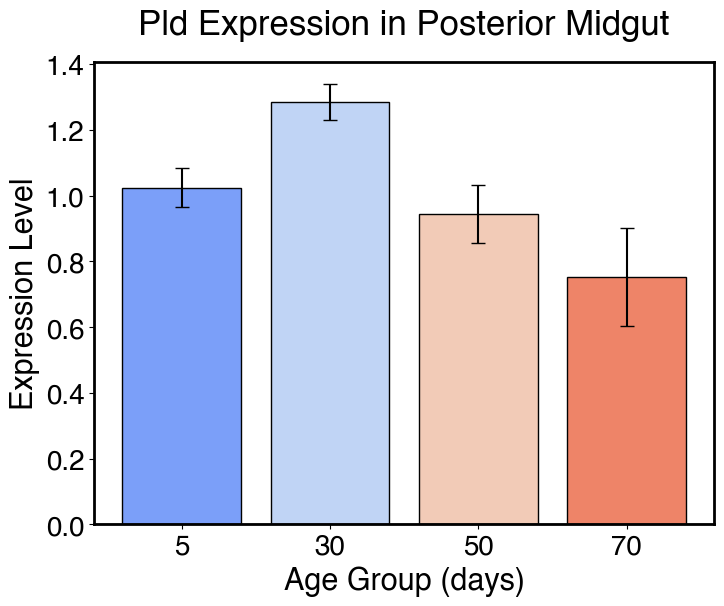

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.cm as cm 

# Define the gene of interest and the specific cell type
gene = 'Pld'
cell_type = 'enterocyte of posterior adult midgut epithelium'

# Extract data for the specific cell type across different ages
ages = [5, 30, 50, 70]
data_list = []


for age in ages:
    age_data = adata[(adata.obs['afca_annotation'] == cell_type) & (np.array(adata.obs['age'], dtype=int) == age)]
    temp = age_data.X[:, np.where(adata.var_names == gene)[0][0]].toarray().flatten()
    data_list.append(pd.DataFrame({'Age': [age] * len(temp), 'Expression': temp}))

# Combine data into a single DataFrame
df = pd.concat(data_list)

# Calculate mean and standard error
means = df.groupby('Age')['Expression'].mean()
errors = df.groupby('Age')['Expression'].apply(sem)

cmap = cm.get_cmap('coolwarm')
colors = cmap(np.linspace(0.2, 0.8, len(means)))

# Create the bar plot with standard error bars
plt.figure(figsize=(8, 6))
plt.bar(means.index.astype(str), means.values, yerr=errors.values, capsize=5, color=colors, edgecolor='black')

# Customize the plot
plt.title(f'{gene} Expression in Posterior Midgut', fontsize=25, pad=20)
plt.xlabel('Age Group (days)', fontsize=22)
plt.ylabel('Expression Level', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='black', linewidth=1)

# bold the x and y borders
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

# helvetica font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Show the plot
plt.show()


In [82]:
df

Cell         5        30        50  \
0                              Kenyon cell  0.000000  2.162438  2.160399   
1              lobula columnar neuron LC12  0.000000  2.140287  2.090279   
2               lamina monopolar neuron L2  2.140857  2.149523  2.030505   
3           subperineurial glial cell_head  2.707405  2.261672  2.066158   
4                   alpha/beta Kenyon cell  2.189141  2.428601  2.171743   
5                    Johnston organ neuron  2.460097  2.390671  2.261264   
6                                cone cell  2.560998  2.584012  2.278344   
7                     epithelial cell_head  2.443468  2.479334  2.239635   
8                              Poxn neuron  1.990006  1.863011  1.562279   
9   proximal medullary amacrine neuron Pm4  2.161343  2.383732  2.431281   
10               olfactory receptor neuron  2.296376  2.305992  2.022899   
11                 dopaminergic PAM neuron  2.222074  2.215413  2.652876   
12    lamina intrinsic amacrine neuron Lai  2.162993  2.362922  2.152327   
13        adult brain cell body glial cell  1.732311  1.801111  1.500142   
14                               neuron 10  1.769127  2.412177  2.162078   
15                 auditory sensory neuron  2.127302  2.002088  1.988610   
16                      columnar neuron T1  1.732167  2.069529  1.911003   
17    distal medullary amacrine neuron Dm9  2.127566  3.432054  2.244085   
18              transmedullary neuron Tm29  1.699078  2.249721  1.821102   
19              lamina monopolar neuron L1  2.356106  2.379000  2.211322   

          70  
0   0.000000  
1   1.987495  
2   1.756881  
3   1.706422  
4   2.125854  
5   2.234438  
6   2.054402  
7   2.054116  
8   1.601961  
9   1.983308  
10  1.845755  
11  2.097096  
12  2.168906  
13  1.298788  
14  1.779518  
15  1.624056  
16  1.679004  
17  2.419812  
18  2.174186  
19  2.236656

In [35]:
age_data = adata[(adata.obs['afca_annotation'] == 'unannotated') & (np.array(adata.obs['age'], dtype=int) == 5)]
temp = age_data.X[:, np.where(adata.var_names == 'Ctl1')[0][0]].toarray().flatten()
len(temp[temp > 0])/len(temp)

0.03803143519711415

In [19]:
adata.obs

tissue     sex age  \
AAACCCACAGTGAGCA-1_AFCA_female_head_30_S1            head  female  30   
AAACCCAGTCCGACGT-1_AFCA_female_head_30_S1            head  female  30   
AAACCCAGTCTTGAGT-1_AFCA_female_head_30_S1            head  female  30   
AAACCCATCGCCAACG-1_AFCA_female_head_30_S1            head  female  30   
AAACGCTGTAGCTGAG-1_AFCA_female_head_30_S1            head  female  30   
...                                                   ...     ...  ..   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult   head  female   5   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult   head  female   5   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult   head  female   5   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult   head  female   5   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult   head  female   5   

                                                      sex_age  \
AAACCCACAGTGAGCA-1_AFCA_female_head_30_S1           female_30   
AAACCCAGTCCGACGT-1_AFCA_female_head_30_S1           female_30   
AAACCCAGTCTTGAGT-1_AFCA_female_head_30_S1           female_30   
AAACCCATCGCCAACG-1_AFCA_female_head_30_S1           female_30   
AAACGCTGTAGCTGAG-1_AFCA_female_head_30_S1           female_30   
...                                                       ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult   female_5   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult   female_5   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult   female_5   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult   female_5   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult   female_5   

                                                    n_genes_by_counts  \
AAACCCACAGTGAGCA-1_AFCA_female_head_30_S1                         853   
AAACCCAGTCCGACGT-1_AFCA_female_head_30_S1                         499   
AAACCCAGTCTTGAGT-1_AFCA_female_head_30_S1                         444   
AAACCCATCGCCAACG-1_AFCA_female_head_30_S1                         566   
AAACGCTGTAGCTGAG-1_AFCA_female_head_30_S1                         463   
...                                                               ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult                334   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult                443   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult                388   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult               1092   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult                468   

                                                    total_counts  \
AAACCCACAGTGAGCA-1_AFCA_female_head_30_S1                 2643.0   
AAACCCAGTCCGACGT-1_AFCA_female_head_30_S1                  794.0   
AAACCCAGTCTTGAGT-1_AFCA_female_head_30_S1                  575.0   
AAACCCATCGCCAACG-1_AFCA_female_head_30_S1                 1173.0   
AAACGCTGTAGCTGAG-1_AFCA_female_head_30_S1                  899.0   
...                                                          ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult         535.0   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult         785.0   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult         660.0   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult        3170.0   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult         853.0   

                                                    total_counts_mt  \
AAACCCACAGTGAGCA-1_AFCA_female_head_30_S1                       2.0   
AAACCCAGTCCGACGT-1_AFCA_female_head_30_S1                       0.0   
AAACCCAGTCTTGAGT-1_AFCA_female_head_30_S1                       0.0   
AAACCCATCGCCAACG-1_AFCA_female_head_30_S1                       3.0   
AAACGCTGTAGCTGAG-1_AFCA_female_head_30_S1                       3.0   
...                                                             ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult              1.0   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult              3.0   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult          

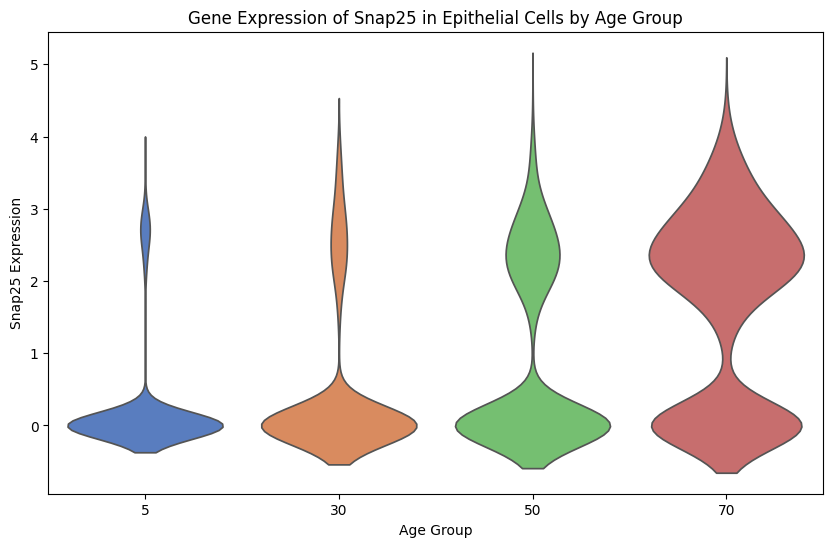

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define the gene of interest
gene = 'Snap25'

# Extract the t-SNE embedding
X_tsne = adata.obsm['X_tsne']
ages = adata.obs['age'].to_numpy(dtype=int)
gene_expression = adata.X[:, np.where(adata.var_names == gene)[0][0]].toarray().flatten()
cell_types = adata.obs['afca_annotation'].to_numpy()

# Filter for epithelial cells
cell = cell_types == 'ensheathing glial cell'

# Create a DataFrame for easy plotting
df = pd.DataFrame(X_tsne[cell], columns=['TSNE1', 'TSNE2'])
df['Age'] = ages[cell]
df['Gene Expression'] = gene_expression[cell]

# Create violin plot of gene expression by age group with scattered points
plt.figure(figsize=(10, 6))
sns.violinplot(x='Age', y='Gene Expression', data=df, palette="muted", inner=None)
#sns.stripplot(x='Age', y='Gene Expression', data=df, color='k', alpha=0.5, jitter=True)
plt.title(f'Gene Expression of {gene} in Epithelial Cells by Age Group')
plt.xlabel('Age Group')
plt.ylabel(f'{gene} Expression')
plt.show()


In [121]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Filter for ensheathing glial cells
cell = 'ensheathing glial cell'
adata_filtered = adata[adata.obs['afca_annotation'] == cell]

# Add age as a categorical variable to obs
adata_filtered.obs['age'] = pd.to_numeric(adata_filtered.obs['age'])
adata_filtered.obs['age'] = pd.cut(adata_filtered.obs['age'], bins=[5, 30, 50, 70], labels=['5', '30', '50'])

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_filtered, groupby='age', method='wilcoxon')

# Extract results into a DataFrame
result = adata_filtered.uns['rank_genes_groups']
groups = result['names'].dtype.names
scores = result['scores']
pvals = result['pvals_adj']
logfc = result['logfoldchanges']

# Create DataFrame for plotting
volcano_df_5to30 = pd.DataFrame({
    'Gene': result['names']['5'],
    'Log2FoldChange': logfc['5'], 
    'P_value': pvals['5']
})

volcano_df_30to50 = pd.DataFrame({
    'Gene': result['names']['30'],
    'Log2FoldChange': logfc['30'], 
    'P_value': pvals['30']
})

volcano_df_50to70 = pd.DataFrame({
    'Gene': result['names']['50'],
    'Log2FoldChange': logfc['50'], 
    'P_value': pvals['50']
})

# Calculate -log10(p-value)
volcano_df_5to30['-log10(P_value)'] = -np.log10(volcano_df_5to30['P_value'])
volcano_df_30to50['-log10(P_value)'] = -np.log10(volcano_df_30to50['P_value'])
volcano_df_50to70['-log10(P_value)'] = -np.log10(volcano_df_50to70['P_value'])

volcano_df_list = [volcano_df_5to30, volcano_df_30to50, volcano_df_50to70]
volcano_titles = ['5 to 30', '30 to 50', '50 to 70']

for volcano_df in volcano_df_list:
    # Create the interactive volcano plot
    fig = px.scatter(
        volcano_df,
        x='Log2FoldChange',
        y='-log10(P_value)',
        hover_data=['Gene'],
        title=f'Volcano Plot of Gene Expression Changes with Age in {cell} for Age Group {volcano_titles.pop(0)}',
        labels={
            'Log2FoldChange': 'Log2 Fold Change',
            '-log10(P_value)': '-log10(P_value)'
        },
        color='-log10(P_value)',
        color_continuous_scale='Viridis'
    )

    significance_threshold = -np.log10(0.05)
    fig.add_trace(
        go.Scatter(
            x=[min(volcano_df['Log2FoldChange']), max(volcano_df['Log2FoldChange'])],
            y=[significance_threshold, significance_threshold],
            mode="lines",
            line=go.scatter.Line(color="red", dash="dash"),
            showlegend=False
        )
    )

    fig.show()

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2327474118.py:17: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [119]:
np.vstack([result['names'][g] for g in groups]).shape

(3, 15992)

In [148]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# these cells are also in the sleep dataset 
cells = ['Kenyon cell', 'alpha/beta Kenyon cell', "alpha'/beta' Kenyon cell", 'antennal lobe projection neuron', 'dopaminergic PAM neuron', 'ensheathing glial cell',
         'gamma Kenyon cell', 'octopaminergic/tyraminergic neuron', 'optic-lobe-associated cortex glial cell', 'adult brain perineurial glial cell']
save_df = pd.DataFrame()
for cell in cells:
    adata_filtered = adata[adata.obs['afca_annotation'] == cell]

    # Add age as a categorical variable to obs
    adata_filtered.obs['age'] = pd.to_numeric(adata_filtered.obs['age'])
    adata_filtered.obs['age'] = pd.cut(adata_filtered.obs['age'], bins=[5, 30, 50, 70], labels=['5', '30', '50'])

    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby='age', method='wilcoxon')

    # Extract results into a DataFrame
    result = adata_filtered.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    scores = result['scores']
    pvals = result['pvals_adj']
    logfc = result['logfoldchanges']

    # Create DataFrame for plotting
    volcano_df_5to30 = pd.DataFrame({
        'Gene': result['names']['5'],
        'Cell': [cell]*len(result['names']['5']),
        'Log2FoldChange_5to30': logfc['5'], 
        'P_value_5to30': pvals['5'], 
    })

    volcano_df_30to50 = pd.DataFrame({
        'Gene': result['names']['30'],
        'Log2FoldChange_30to50': logfc['30'], 
        'P_value_30to50': pvals['30'], 
    })

    volcano_df_50to70 = pd.DataFrame({
        'Gene': result['names']['50'],
        'Log2FoldChange_50to70': logfc['50'], 
        'P_value_50to70': pvals['50'], 
    })

    # Calculate -log10(p-value)
    volcano_df_5to30['-log10(P_value)_5to30'] = -np.log10(volcano_df_5to30['P_value_5to30'])
    volcano_df_30to50['-log10(P_value)_30to50'] = -np.log10(volcano_df_30to50['P_value_30to50'])
    volcano_df_50to70['-log10(P_value)_50to70'] = -np.log10(volcano_df_50to70['P_value_50to70'])

    # Sort by gene name 
    volcano_df_5to30 = volcano_df_5to30.sort_values(by='Gene')
    volcano_df_30to50 = volcano_df_30to50.sort_values(by='Gene')
    volcano_df_50to70 = volcano_df_50to70.sort_values(by='Gene')
   

    # drop the "Gene" column from the dataframes
    volcano_df_30to50 = volcano_df_30to50.drop(columns = ['Gene'])
    volcano_df_50to70 = volcano_df_50to70.drop(columns = ['Gene'])
    
    volcano_df = pd.concat([volcano_df_5to30, volcano_df_30to50, volcano_df_50to70], axis=1)
    save_df = pd.concat([save_df, volcano_df], axis=0)

save_df.to_csv('deg_afca.csv', index=False)

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2250122092.py:20: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2250122092.py:20: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2250122092.py:20: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2250122092.py:20: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/2250122092.py:20: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_68317/22501

In [206]:
import scanpy as sc
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Genes list
genes = np.array(['InR', 'Imp'])

# Cells in the sleep dataset
cells = ["midgut large flat cell", "enterocyte of posterior adult midgut epithelium", "enterocyte of anterior adult midgut epithelium", "adult fat body_body", "epithelial cell_body", "posterior midgut*", "adult midgut enterocyte"]
save_df = pd.DataFrame()
for cell in ['ensheathing glial cell']:
    adata_filtered = adata[adata.obs['afca_annotation'] == cell]

    # Change the age binning
    adata_filtered.obs['age'] = pd.to_numeric(adata_filtered.obs['age'])
    adata_filtered.obs['age'] = pd.cut(adata_filtered.obs['age'], bins=[5, 70], labels=['5to70'])

    # Differential expression analysis for the modified bins
    sc.tl.rank_genes_groups(adata_filtered, groupby='age', method='wilcoxon')

    # Extract results into a DataFrame for the 5 to 70 years comparison
    result = adata_filtered.uns['rank_genes_groups']
    volcano_df_5to70 = pd.DataFrame({
        'Gene': result['names']['5to70'],
        'Cell': [cell]*len(result['names']['5to70']),
        'Log2FoldChange_5to70': result['logfoldchanges']['5to70'], 
        'P_value_5to70': result['pvals_adj']['5to70'], 
        '-log10(P_value)_5to70': -np.log10(result['pvals_adj']['5to70'])
    })
    volcano_df_5to70 = volcano_df_5to70.sort_values(by='Gene')
    save_df = pd.concat([save_df, volcano_df_5to70], axis=0)

    # Plot the volcano plot
    fig = px.scatter(
        volcano_df_5to70,
        x='Log2FoldChange_5to70',
        y='-log10(P_value)_5to70',
        hover_data=['Gene'],
        title=f'<br>'.join([f'Volcano Plot of Gene Expression Changes with Age', f'in {cell}']),
        labels={
            'Log2FoldChange_5to70': 'Log2 Fold Change',
            '-log10(P_value)_5to70': '-Log10 P value'
        },
        color='-log10(P_value)_5to70',
        color_continuous_scale='Viridis'
    )

    # Add significance threshold line
    significance_threshold = -np.log10(0.05)
    fig.add_trace(
        go.Scatter(
            x=[min(volcano_df_5to70['Log2FoldChange_5to70']), max(volcano_df_5to70['Log2FoldChange_5to70'])],
            y=[significance_threshold, significance_threshold],
            mode="lines",
            line=dict(color="red", dash="dash"),
            showlegend=False
        )
    )

    # Highlight and label specific genes in red
    gene_data = volcano_df_5to70[volcano_df_5to70['Gene'].isin(genes)]
    fig.add_trace(
        go.Scatter(
            x=gene_data['Log2FoldChange_5to70'],
            y=gene_data['-log10(P_value)_5to70'],
            mode='markers+text',
            text=gene_data['Gene'],
            textposition='top center',
            marker=dict(color='red', size=10, line=dict(width=2, color='DarkSlateGrey')),
            showlegend=False
        )
    )

    fig.update_layout(
        autosize=False,
        width=800,
        height=600,
        template='plotly_white'
    ) 
    
    fig.show()

# Save the results to a CSV file
#save_df.to_csv('deg_5_to_70_years_body.csv', index=False)


/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_6218/2220680958.py:17: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_6218/2220680958.py:30: RuntimeWarning:

divide by zero encountered in log10



/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_6218/380743057.py:17: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



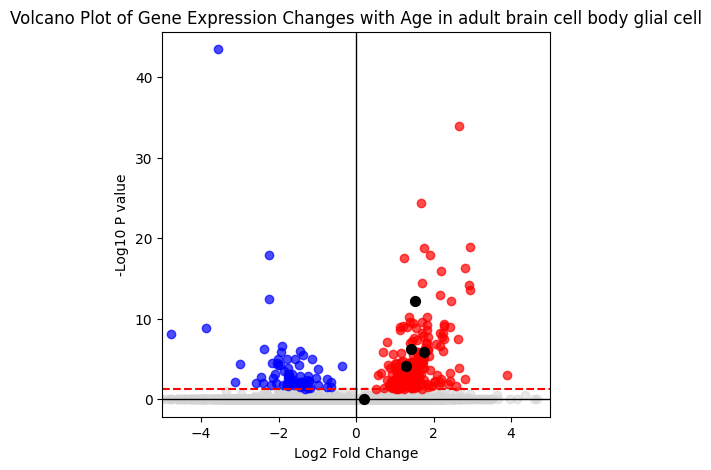

In [239]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Genes list
genes = np.array(['InR', 'Myc', 'REPTOR', 'l(3)80Fj', 'Imp'])


# Cells in the sleep dataset
cells = ["midgut large flat cell", "enterocyte of posterior adult midgut epithelium", "enterocyte of anterior adult midgut epithelium", "adult fat body_body", "epithelial cell_body", "posterior midgut*", "adult midgut enterocyte"]
save_df = pd.DataFrame()
for cell in ["adult brain cell body glial cell"]:
    adata_filtered = adata[adata.obs['afca_annotation'] == cell]

    # Change the age binning
    adata_filtered.obs['age'] = pd.to_numeric(adata_filtered.obs['age'])
    adata_filtered.obs['age'] = pd.cut(adata_filtered.obs['age'], bins=[5, 70], labels=['5to70'])

    # Differential expression analysis for the modified bins
    sc.tl.rank_genes_groups(adata_filtered, groupby='age', method='wilcoxon')

    # Extract results into a DataFrame for the 5 to 70 years comparison
    result = adata_filtered.uns['rank_genes_groups']
    volcano_df_5to70 = pd.DataFrame({
        'Gene': result['names']['5to70'],
        'Cell': [cell]*len(result['names']['5to70']),
        'Log2FoldChange_5to70': result['logfoldchanges']['5to70'], 
        'P_value_5to70': result['pvals_adj']['5to70'], 
        '-log10(P_value)_5to70': -np.log10(result['pvals_adj']['5to70'])
    })
    volcano_df_5to70 = volcano_df_5to70.sort_values(by='Gene')
    save_df = pd.concat([save_df, volcano_df_5to70], axis=0)

    # Plot the volcano plot using matplotlib
    plt.figure(figsize=(5, 5))
    
    # Add significance threshold line
    significance_threshold = -np.log10(0.05)
    plt.axhline(y=significance_threshold, color='red', linestyle='--')

    # Plot all points below the significance threshold in light gray
    non_significant = volcano_df_5to70[volcano_df_5to70['-log10(P_value)_5to70'] < significance_threshold]
    plt.scatter(non_significant['Log2FoldChange_5to70'], non_significant['-log10(P_value)_5to70'], c='lightgray', alpha=0.5)

    # Plot significant points with positive fold change in red and negative fold change in blue
    significant_positive = volcano_df_5to70[(volcano_df_5to70['-log10(P_value)_5to70'] >= significance_threshold) & (volcano_df_5to70['Log2FoldChange_5to70'] > 0)]
    significant_negative = volcano_df_5to70[(volcano_df_5to70['-log10(P_value)_5to70'] >= significance_threshold) & (volcano_df_5to70['Log2FoldChange_5to70'] < 0)]
    
    plt.scatter(significant_positive['Log2FoldChange_5to70'], significant_positive['-log10(P_value)_5to70'], c='red', alpha=0.7)
    plt.scatter(significant_negative['Log2FoldChange_5to70'], significant_negative['-log10(P_value)_5to70'], c='blue', alpha=0.7)

    # Highlight and label specific genes
    for gene in genes:
        if gene in volcano_df_5to70['Gene'].values:
            gene_data = volcano_df_5to70[volcano_df_5to70['Gene'] == gene]
            plt.scatter(gene_data['Log2FoldChange_5to70'], gene_data['-log10(P_value)_5to70'], c='black', s=50)
            #plt.text(gene_data['Log2FoldChange_5to70'], gene_data['-log10(P_value)_5to70'], gene, fontsize=12, ha='right')

    # Customize plot appearance
    plt.title(f'Volcano Plot of Gene Expression Changes with Age in {cell}')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 P value')
    plt.xlim(-5, 5)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1)
    plt.grid(False)  # Remove gridlines
    plt.gca().set_facecolor('white')  # White background
    plt.show()

# Save the results to a CSV file
#save_df.to_csv('deg_5_to_70_years_body.csv', index=False)


In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Genes list
genes = np.array([
    'Vps11',
    'SNF4Agamma',
    'Imp',
    'Sec16',
    'CaMKII',
    'lt',
    'crc',
    'REPTOR',
    'HDAC4',
    'spin',
    'rudhira',
    'Myc',
    'l(3)80Fj',
    'InR',
    'Mitf',
    'Bruce',
    'rl',
    'Sh',
    'Ac76E'
])

# Cells in the sleep dataset
cells = ['Kenyon cell', 'alpha/beta Kenyon cell', "alpha'/beta' Kenyon cell", 'antennal lobe projection neuron', 'dopaminergic PAM neuron', 'ensheathing glial cell',
         'gamma Kenyon cell', 'octopaminergic/tyraminergic neuron', 'optic-lobe-associated cortex glial cell', 'adult brain perineurial glial cell']
save_df = pd.DataFrame()
for cell in ["ensheathing glial cell"]:
    adata_filtered = adata[adata.obs['afca_annotation'] == cell]

    # Change the age binning
    adata_filtered.obs['age'] = pd.to_numeric(adata_filtered.obs['age'])
    adata_filtered.obs['age'] = pd.cut(adata_filtered.obs['age'], bins=[5, 70], labels=['5to70'])

    # Differential expression analysis for the modified bins
    sc.tl.rank_genes_groups(adata_filtered, groupby='age', method='wilcoxon')

    # Extract results into a DataFrame for the 5 to 70 years comparison
    result = adata_filtered.uns['rank_genes_groups']
    volcano_df_5to70 = pd.DataFrame({
        'Gene': result['names']['5to70'],
        'Cell': [cell]*len(result['names']['5to70']),
        'Log2FoldChange_5to70': result['logfoldchanges']['5to70'], 
        'P_value_5to70': result['pvals_adj']['5to70'], 
        '-log10(P_value)_5to70': -np.log10(result['pvals_adj']['5to70'])
    })
    volcano_df_5to70 = volcano_df_5to70.sort_values(by='Gene')
    save_df = pd.concat([save_df, volcano_df_5to70], axis=0)

# Filter the DataFrame to include only the genes of interest
filtered_df = save_df[save_df['Gene'].isin(genes)]

# Plot the filtered genes
fig = px.scatter(
    filtered_df,
    x='Log2FoldChange_5to70',
    y='-log10(P_value)_5to70',
    hover_data=['Gene'],
    title='Differential Gene Expression with Age in Ensheathing Glial Cells',
    labels={
        'Log2FoldChange_5to70': 'Log2 Fold Change',
        '-log10(P_value)_5to70': '-log10(P_value)'
    },
    color='-log10(P_value)_5to70',
    color_continuous_scale='Viridis'
)

# Highlight and label specific genes in red
fig.add_trace(
    go.Scatter(
        x=filtered_df['Log2FoldChange_5to70'],
        y=filtered_df['-log10(P_value)_5to70'],
        mode='markers+text',
        text=filtered_df['Gene'],
        textposition='top center',
        marker=dict(color='red', size=10),
        showlegend=False
    )
)

# Add significance threshold line
significance_threshold = -np.log10(0.05)
fig.add_trace(
    go.Scatter(
        x=[min(volcano_df_5to70['Log2FoldChange_5to70']), max(volcano_df_5to70['Log2FoldChange_5to70'])],
        y=[significance_threshold, significance_threshold],
        mode="lines",
        line=go.scatter.Line(color="red", dash="dash"),
        showlegend=False
    )
)

fig.update_xaxes(range = [-5, 5])
fig.update_yaxes(range = [0, 10])
fig.show()


/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_32748/2338083034.py:38: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/3p/cyznwqtj0vx0xcb63yzgkvx80000gn/T/ipykernel_32748/2338083034.py:51: RuntimeWarning:

divide by zero encountered in log10



In [147]:
cells = ['Kenyon cell', 'alpha/beta Kenyon cell', "alpha'/beta' Kenyon cell", 'antennal lobe projection neuron', 'dopaminergic PAM neuron', 'ensheathing glial cell',
         'gamma Kenyon cell', 'octopaminergic/tyraminergic neuron', 'optic-lobe-associated cortex glial cell', 'adult brain perineurial glial cell']

In [84]:
# Get all of the genes that are significantly differentially expressed 
# between the age groups in the ensheathing glial cells

deg = volcano_df[volcano_df['P_value'] < 0.05]
negatives = deg[deg['Log2FoldChange'] < 0]
positives = deg[deg['Log2FoldChange'] > 0]

negative_genes = np.array(negatives['Gene'].values)
positive_genes = np.array(positives['Gene'].values)

# save the differentially expressed genes to a file
np.save('negative_genes_age.npy', negative_genes)
np.save('positive_genes_age.npy', positive_genes)

In [75]:
# count the number of genes that are significantly differentially expressed

# Define the significance threshold
significance_threshold = 0.05

# Count the number of significantly differentially expressed genes
num_sig_genes = sum(volcano_df['P_value'] < significance_threshold)
num_insig_genes = sum(volcano_df['P_value'] >= significance_threshold)